In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Load data

In [51]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [53]:
# check the data
mnist.data[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [54]:
# size of the mnist data set
mnist.data.shape

(70000, 784)

In [55]:
# check the target
mnist.target[0], len(mnist.target), type(mnist.target[0])

('5', 70000, str)

In [56]:
# change the type of the target values (string -> integer)
mnist.target = mnist.target.astype(np.int8)

In [57]:
# define X and y
X = mnist.data / 255  # normalization, as the range of data is 0(white) ~ 255(black), it is divided by 255
y = mnist.target

The label of this image is 5.


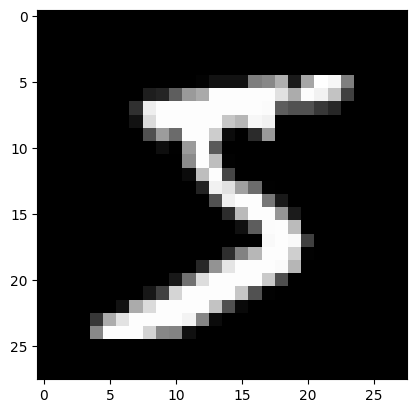

In [60]:
# visualize the data
plt.imshow(X[0].reshape(28,28), cmap='gray')
print('The label of this image is {:.0f}.'.format(y[0]))

# 2. Train/test split

In [61]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

# from numpy array to pytorch tensor
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# make Dataset objects
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# Dataset -> DataLoader
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

# 3. Multilayer perceptron

In [63]:
from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100,10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [64]:
from torch import optim

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [65]:
# function for model training
def train(epoch):
  model.train()   # train mode of neural network (e.g. Dropout can be applied)

  for data, targets in loader_train:
    optimizer.zero_grad()
    prediction = model(data)
    loss = loss_fn(prediction, targets)   # CrossEntropyLoss function can handle a class index directly
    loss.backward()
    optimizer.step()

  print("epoch{}: completed\n".format(epoch))

In [66]:
# function for model test
def test():
  model.eval()    # test mode of neural network
  correct = 0

  with torch.no_grad():   # no gradient is necessary for testing
    for data, targets in loader_test:
      outputs = model(data)
      _, predicted = torch.max(outputs.data, 1)   # calculate what label has the highest probability
      correct += predicted.eq(targets.data.view_as(predicted)).sum()    # add a count when prediction is correct

  data_num = len(loader_test.dataset)
  print('\naccuracy of test data: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100.*correct / data_num))

In [67]:
import torch
# test results without model training
test()


accuracy of test data: 1015/10000 (10%)



In [68]:
# model training (epoch=3)
for epoch in range(3):
  train(epoch)

test()    # test the model

epoch0: completed

epoch1: completed

epoch2: completed


accuracy of test data: 9537/10000 (95%)



tensor([-10.7919, -12.1888,  -3.7620,   0.0357,  -4.6928,  -5.8169, -21.7817,
         16.8967,  -2.1532,  -0.0229])
predicted result: 7
The correct label for this data is 7


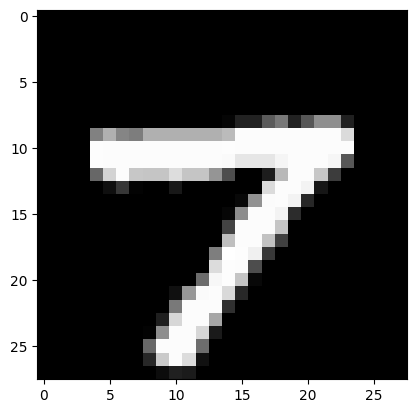

In [72]:
# check the results of test data
index = 20

model.eval()
data = X_test[index]
output = model(data)
print(output.data)
_, predicted = torch.max(output.data, 0)

print("predicted result: {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28,28), cmap='gray')
print('The correct label for this data is {:.0f}'.format(y_test[index]))